In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS, TSNE
from deslib.util.diversity import double_fault
import matplotlib.lines as mlines
from umap import UMAP

# Get the pairwise diversity matrix

In [2]:
def compute_pairwise_diversity_matrix(targets, prediction_matrix, diversity_func):
    """Computes the pairwise diversity matrix.

     Parameters
     ----------
     targets : array of shape (n_samples):
        Class labels of each sample in X.

     prediction_matrix : array of shape (n_samples, n_classifiers):
        Predicted class labels for each classifier in the pool

     diversity_func : Function
        Function used to estimate the pairwise diversity

     Returns
     -------
     diversity : array of shape = [n_classifiers]
        The average pairwise diversity matrix calculated for the pool of
        classifiers

     """
    n_classifiers = prediction_matrix.shape[1]
    diversity = np.zeros((n_classifiers, n_classifiers))
    for clf_index in range(n_classifiers):
        for clf_index2 in range(clf_index + 1, n_classifiers):
            this_diversity = diversity_func(targets,
                                            prediction_matrix[:, clf_index],
                                            prediction_matrix[:, clf_index2])

            diversity[clf_index, clf_index2] = this_diversity
            diversity[clf_index2, clf_index] = this_diversity

    return diversity

In [3]:
def load_predictions(dataset_name):
    path = './Saved_Predict_and_Proba/' + dataset_name.upper() + '/pred_val_' + dataset_name.lower() + '.csv'
    table_pred = pd.read_csv(path)
    print(dataset_name)
    if dataset_name == 'hateval':
        label = table_pred["HS"]
        methods = table_pred.drop('HS', axis=1)
    elif dataset_name == 'zw':
        label = table_pred['norm']
        methods = table_pred.drop('norm', axis=1)
    else: 
        label = table_pred['class']
        methods = table_pred.drop('class', axis=1)
    methods = methods.drop('Unnamed: 0', axis=1)
    return label, methods

def compute_matrix_embedding(dataset_name, n_classifiers, n_features, method='mds', n_neighbors=5, min_dist=0.7
):
    D = compute_pairwise_diversity_matrix(label.to_numpy(), methods.to_numpy(), double_fault)
    D = 1/D
    D[D==np.inf] = 0
    if method == 'mds':
        method = MDS(dissimilarity='precomputed', random_state=123456987, n_init=20, max_iter=100000)
    elif method == 'tsne':
        method = TSNE(perplexity=25, init='pca', random_state=42, early_exaggeration=50, 
                      learning_rate=200, n_iter=2500, angle=0.5)
    else:        
        method = UMAP(n_neighbors=2, metric='euclidean', random_state=123456987, min_dist=0.7, n_components=2,)
    D_tilde = method.fit_transform(D)
    D_tilde = D_tilde.reshape(n_classifiers, n_features, 2)
    return D_tilde

# Plotting

In [4]:
from matplotlib import pyplot as plt
def plot_diversity(D_changed, method_tmp, dataset_name, title):
    s = 100
    colors = {}
    colors[0] = '#DAA520'
    colors[1] = '#FF0000'
    colors[2] = '#0000FF'
    colors[3] = '#228B22'
    colors[4] = '#000000'
    markers = {}
    markers[0] = 'X'
    markers[1] = 'd'
    markers[2] = '*'
    markers[3] = "^"
    markers[4] = 'o'
    n_classifiers, n_features, _ = D_changed.shape
    plt.figure(figsize=(15,10))
    method=0
    for idx in range(n_classifiers):
        for idx2 in range(n_features):
            x, y = D_changed[idx,idx2, 0], D_changed[idx,idx2, 1]
            plt.scatter(x, y, color=colors[idx2], s=s, lw=0, marker=markers[idx2])
            plt.annotate(method_tmp[method], xy=(x, y), textcoords='offset points', xytext=(5, 15), ha='right', va='top')  
            method += 1
    
    m1 = mlines.Line2D([], [], color=colors[0], marker=markers[0], linestyle='None', markersize=10, label='CV')
    m2 = mlines.Line2D([], [], color=colors[1], marker=markers[1], linestyle='None', markersize=10, label='TFIDF')
    m3 = mlines.Line2D([], [], color=colors[2], marker=markers[2], linestyle='None', markersize=10, label='Glove')
    m4 = mlines.Line2D([], [], color=colors[3], marker=markers[3], linestyle='None', markersize=10, label='Word2Vec')
    m5 = mlines.Line2D([], [], color=colors[4], marker=markers[4], linestyle='None', markersize=10, label='FastText')
    plt.title(title + " " + dataset_name.upper()+' dataset')
    plt.legend(handles=[m1, m2, m3, m4, m5])
    plt.tight_layout()
    plt.savefig(title + " " + dataset_name.upper()+' dataset.pdf', dpi=450)

hateval


C:\Users\Rafael\Anaconda3\envs\hate_speech\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


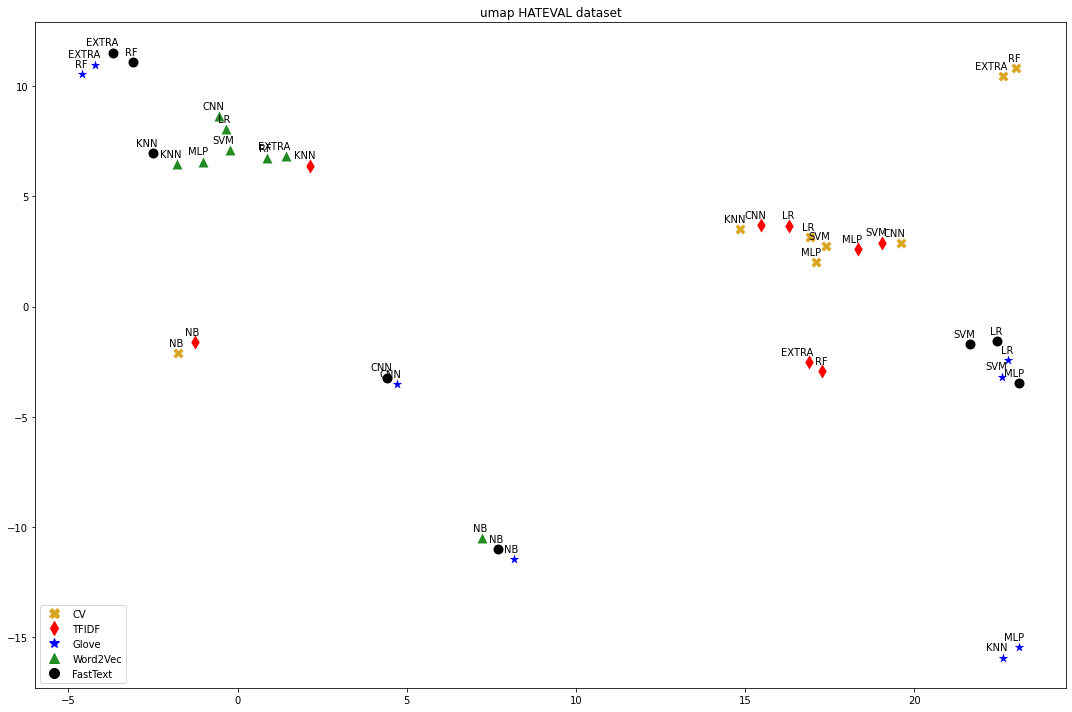

In [5]:
n_classifiers = 8
method = 'umap'
n_features = 5
for dataset_name in ['hateval']:
    
    label, methods = load_predictions(dataset_name)
    methods_name = [name.split('-', 1)[0] for name in methods.columns]
    D_tilde = compute_matrix_embedding(dataset_name, n_classifiers, n_features, method)
    plot_diversity(D_tilde, methods_name, dataset_name, method)